In [1]:
using Turing 
using Distributions
using Random
using Statistics
using StatsFuns

using CSVFiles
using DataFrames

using CairoMakie
using StatsPlots
CairoMakie.activate!()

### section 5-2
#### logistic regression

In [ ]:
df = DataFrame(load(File(format"CSV", "data-attendance-2.txt")))

# A: アルバイトが好き => 1, 嫌い => 0
# Score: 学問への興味: 0 ~ 200
# M: 総授業回数
# Y: 出席回数

Row,PersonID,A,Score,M,Y
,Int64,Int64,Int64,Int64,Int64
1,1,0,69,43,38
2,2,1,145,56,40
3,3,0,125,32,24
4,4,1,86,45,33
5,5,1,158,33,23
6,6,0,133,61,60
7,7,0,111,49,35
8,8,1,147,76,47
9,9,0,146,78,63


In [3]:
df_join_ratio = DataFrame(ratio = df.Y ./ df.M)
df2 = hcat(df, df_join_ratio)

Row,PersonID,A,Score,M,Y,ratio
,Int64,Int64,Int64,Int64,Int64,Float64
1,1,0,69,43,38,0.883721
2,2,1,145,56,40,0.714286
3,3,0,125,32,24,0.75
4,4,1,86,45,33,0.733333
5,5,1,158,33,23,0.69697
6,6,0,133,61,60,0.983607
7,7,0,111,49,35,0.714286
8,8,1,147,76,47,0.618421
9,9,0,146,78,63,0.807692


In [ ]:
# scatter plot matrix
function scatter_matrix(df, cols)
    N_col = length(cols)
    labels = string.(cols)
    
    fig = Figure(size=(1500, 1500))
    ax_matrix = [Axis(fig[i, j], xlabel = labels[j], xlabelsize = 30, ylabel = labels[i], ylabelsize = 30) for i = 1 : N_col, j = 1 : N_col]
    for i = 1 : N_col, j = 1 : N_col
        if i != N_col
            hidexdecorations!(ax_matrix[i, j], grid=false)
        end
        if j != 1
            hideydecorations!(ax_matrix[i, j], grid=false)
        end
    end

    # diagonal plot
    for (i, col) ∈ enumerate(cols)
        if i == 1
            hist!(ax_matrix[i, i], df[df.A .== 0, col], color = (:orange, 0.5), strokewidth = 1, strokecolor = :black)
            hist!(ax_matrix[i, i], df[df.A .== 1, col], color = (:green, 0.5), strokewidth = 1, strokecolor = :black)
        else 
            Makie.density!(ax_matrix[i, i], df[!, col], color = (:gray50, 0.9))
            hist!(ax_matrix[i, i], df[!, col], color = (:blue, 0.5), strokewidth = 1, strokecolor = :black, normalization = :pdf)
        end
    end

    # upper diagonal plot 
    for i = 1 : N_col - 1
        for j = i+1 : N_col
            _correlation_plot!(ax_matrix[i, j], df[!, cols[i]], df[!, cols[j]])
        end
    end

    # lower diagonal plot 
    colors = [(:orange, 0.7), (:green, 0.7)]
    markers = [:circle, :utriangle]
    Random.seed!(1234)
    random_offsets = 0.3 .* (rand(Float64, nrow(df)) .- 0.5) 
    for j = 1 : N_col - 1
        for i = j+1 : N_col
            if j == 1 
                Makie.boxplot!(ax_matrix[i, j], df[!, :A], df[!, cols[i]], color = :white, strokewidth = 1, strokecolor = :black)
                Makie.scatter!(ax_matrix[i, j], df[!, :A] + random_offsets, df[!, cols[i]], color = colors[df.A .+ 1], markersize = 20, marker = markers[df.A .+ 1])
            else
                Makie.scatter!(ax_matrix[i, j], df[df.A .== 0, cols[j]], df[df.A .== 0, cols[i]], markersize = 20, marker = :circle, color = (:orange, 0.7))
                Makie.scatter!(ax_matrix[i, j], df[df.A .== 1, cols[j]], df[df.A .== 1, cols[i]], markersize = 20, marker = :utriangle, color = (:green, 0.7))
            end
        end
    end

    display(fig)
end

function _correlation_plot!(axis, data1, data2)
    pearson_cor = cor(data1, data2)

    color_scale = min(0.01 + abs(pearson_cor), 0.8)
    θ = sign(pearson_cor) * (π / 4.0)
    ellipse_scale = 1.0 - abs(pearson_cor) * 0.5
    ellipse_polygon = Point2f.(zip(_ellipse_points(0, 0, ellipse_scale, 1.0 / ellipse_scale, θ)...))

    hidedecorations!(axis)
    hidespines!(axis)
    plot = poly!(axis, ellipse_polygon, color = color_scale, colormap = :blues, colorrange = (0, 1.0))
    text!(axis, 0, 0, text = "$(round(pearson_cor, digits=2))", align = (:center, :center), fontsize = 50)
end

function _ellipse_points(center_x, center_y, radius_x, radius_y, θ; points=100)
	t = range(0, 2*pi, length=points)
	ellipse_x_r = radius_x .* cos.(t)
	ellipse_y_r = radius_y .* sin.(t)
	R = [cos(θ) -sin(θ); sin(θ) cos(θ)]
	r_ellipse = [ellipse_x_r ellipse_y_r] * R
	x = center_x .+ r_ellipse[:, 1]
	y = center_y .+ r_ellipse[:, 2]
	return (x, y)
end

_ellipse_points (generic function with 1 method)

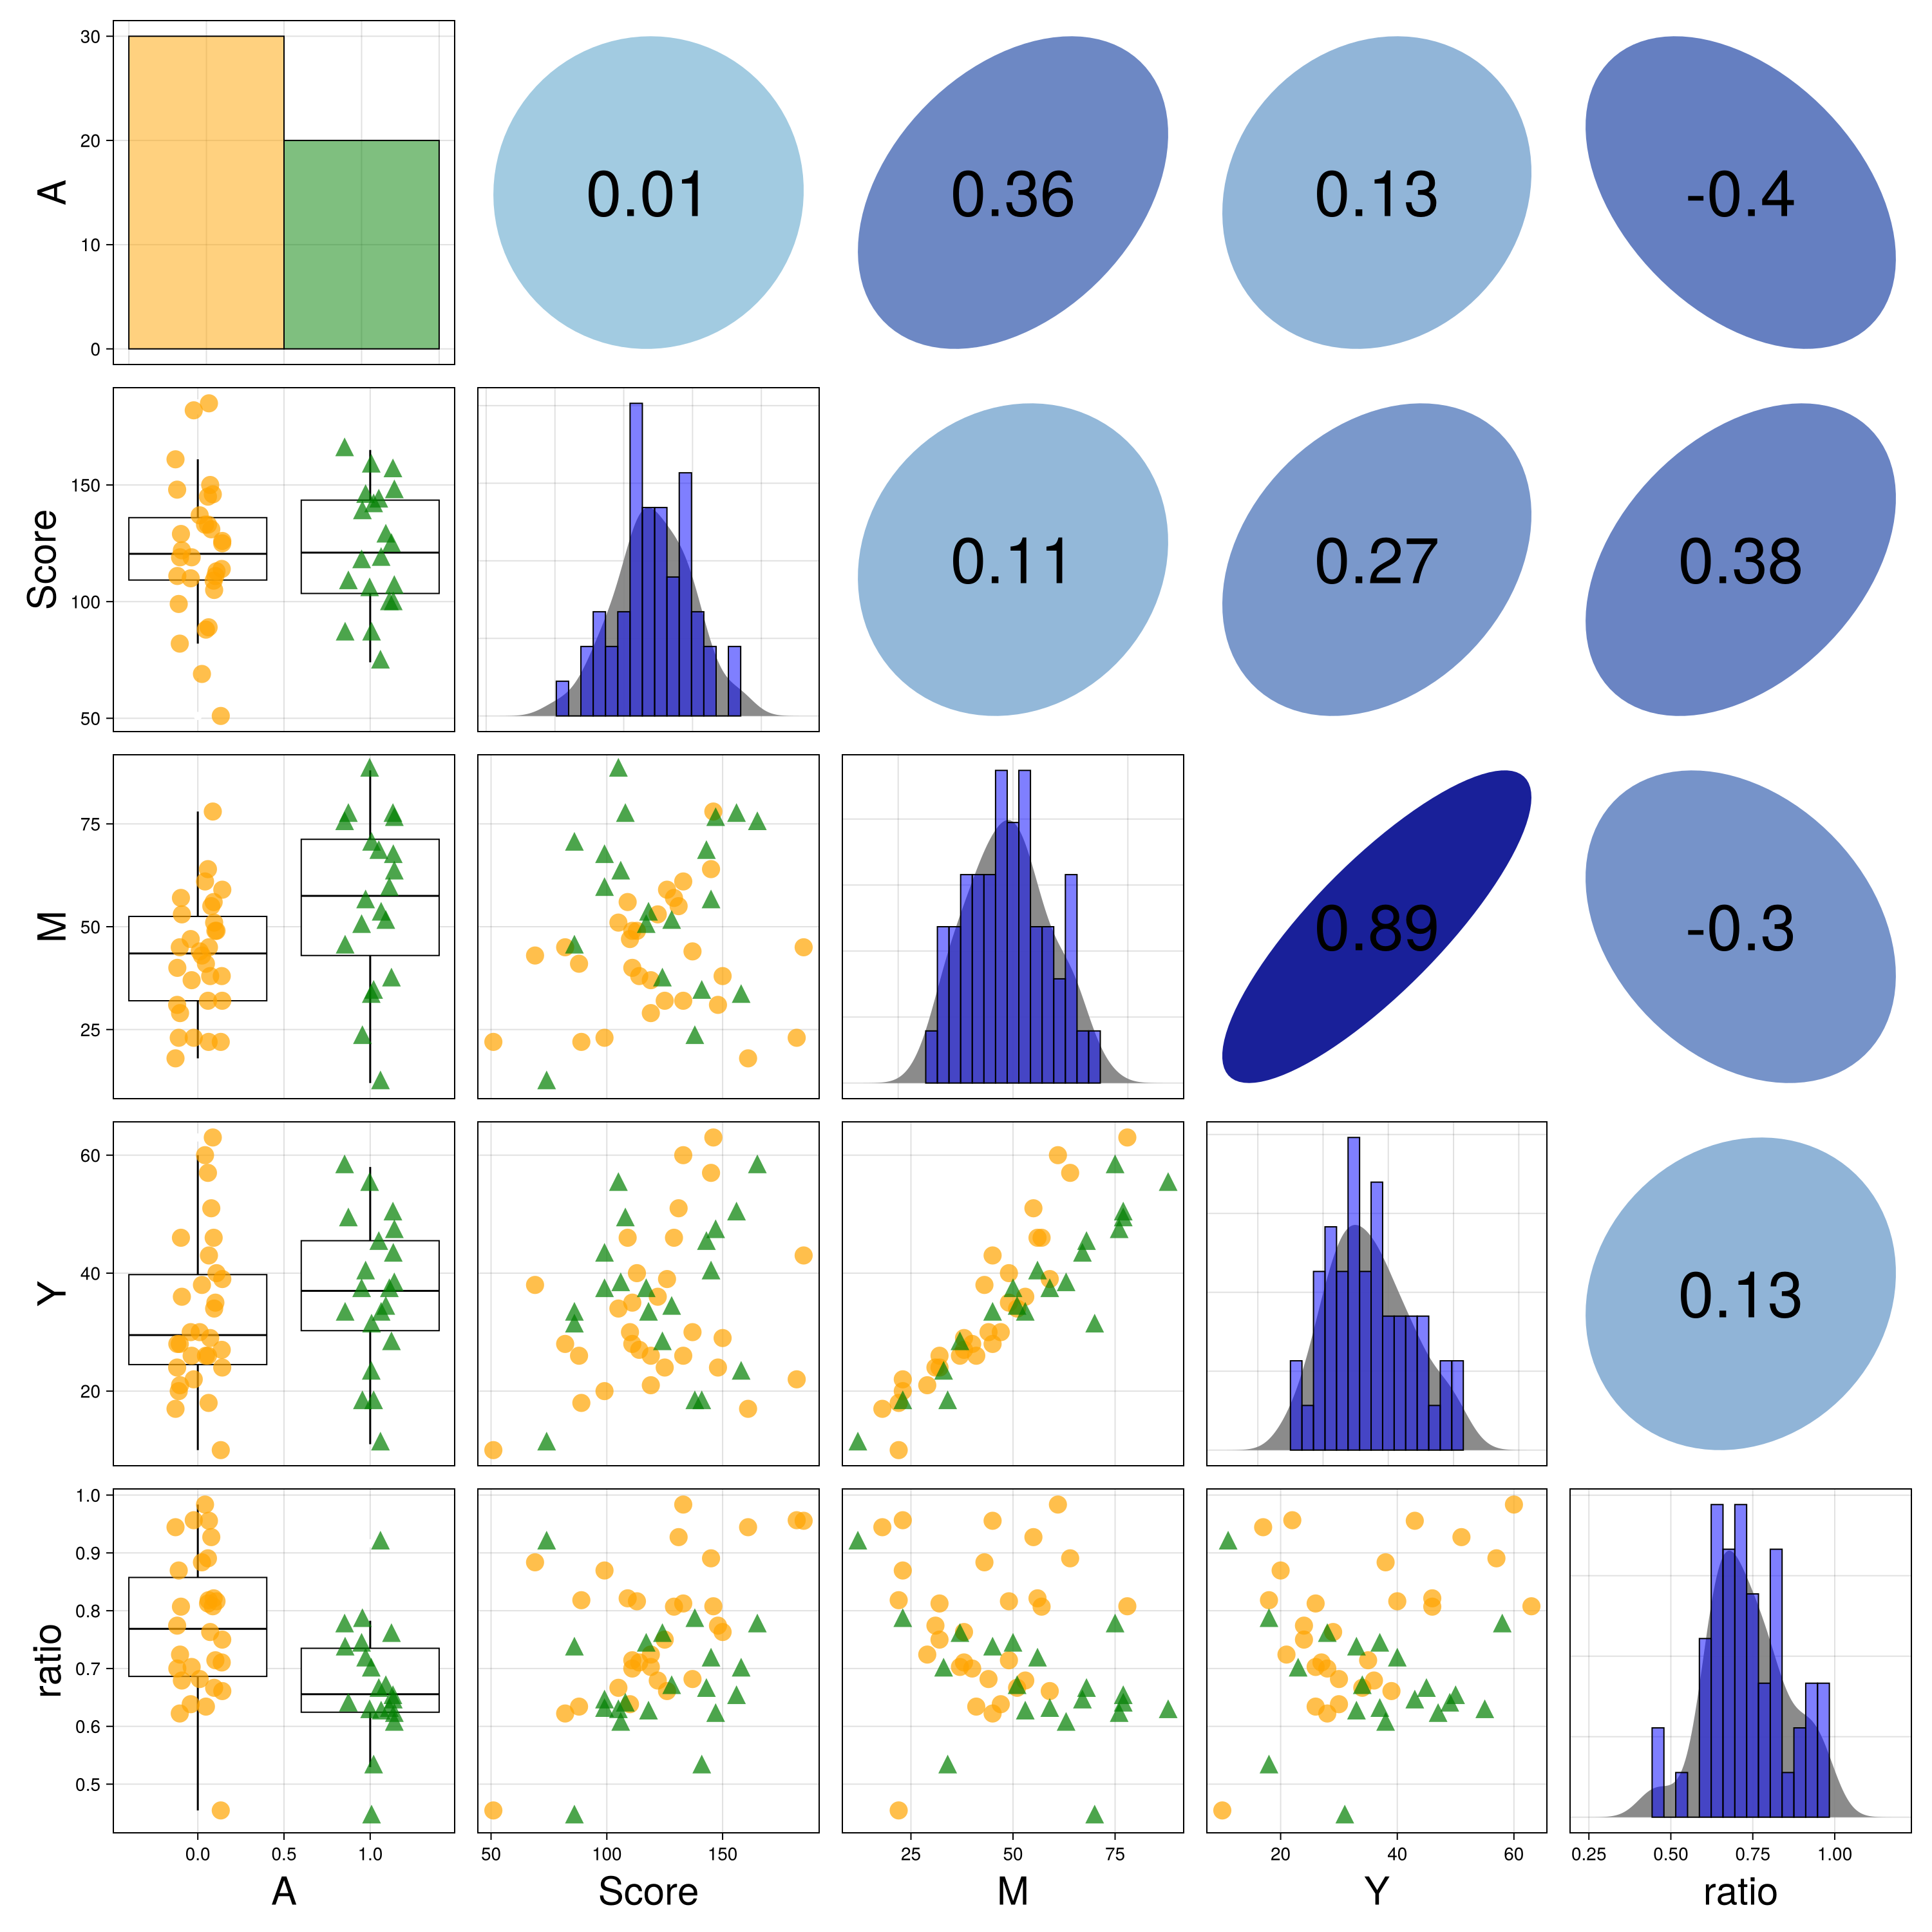

CairoMakie.Screen{IMAGE}


In [5]:
scatter_matrix(df2, [:A, :Score, :M, :Y, :ratio])

In [6]:
# 仮説：ratio(=Y/M, 出席率)はAとScoreによって（線形に）説明できる
# 総授業回数 M と、出席率 ratio をパラメータとする二項分布によって Y が予想できる
@model function logistic_reg(A, Score, Y, M)
    # prior distribution
    b_0 ~ Normal(0, 100)
    b_A ~ Normal(0, 100)
    b_score ~ Normal(0, 100)

    # scaling 
    score_scale = 200

    # model
    for i = 1 : length(A)
        p = StatsFuns.logistic(b_0 + b_A * A[i] + (b_score / score_scale) * Score[i])
        Y[i] ~ Binomial(M[i], p)
    end
end

logistic_reg (generic function with 2 methods)

In [7]:
A = df[!, :A]
Score = df[!, :Score]
Y = df[!, :Y]
M = df[!, :M]
chain = sample(logistic_reg(A, Score, Y, M), NUTS(), 1000)

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (1000×17×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 11.82 seconds
Compute duration  = 11.82 seconds
parameters        = b_0, b_A, b_score
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

         b_0    0.0784    0.2128    0.0094   518.4167   516.5868    0.9990     ⋯
         b_A   -0.6241    0.0858    0.0036   575.6720   424.7788    0.9992     ⋯
     b_score    1.9314    0.3360    0.0148   516.0368   606.0336    1.0000     ⋯
                                                                1 column omitted

Quantiles
  parameters      2

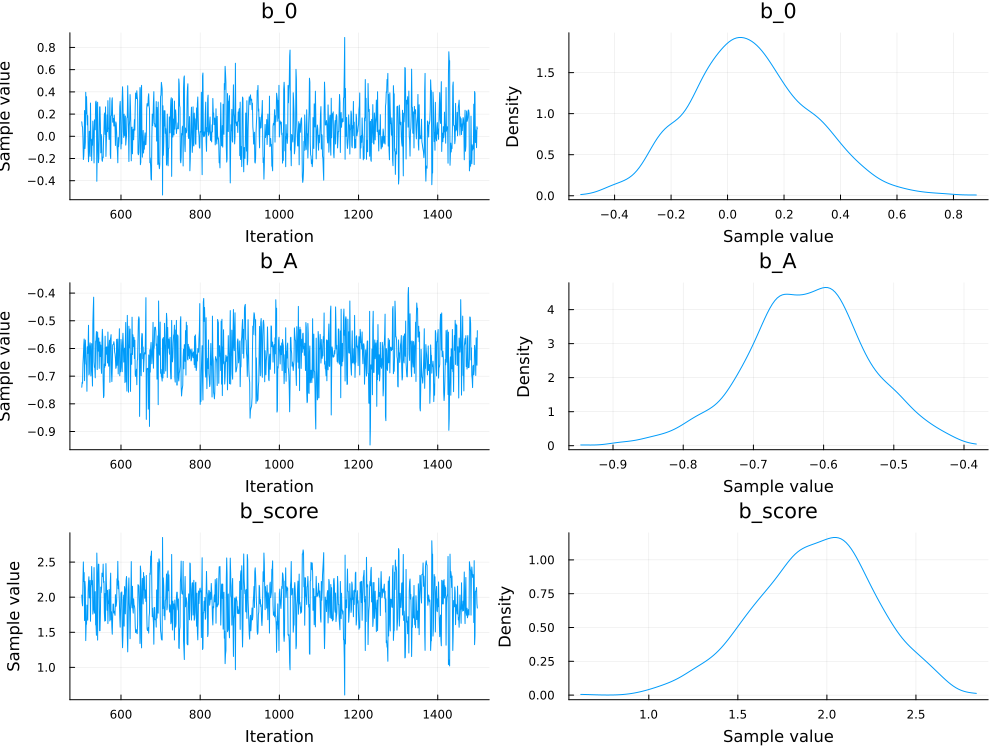

In [8]:
StatsPlots.plot(chain)

In [ ]:
score_pred = collect(1 : 200)
A0 = df.A .== 0
A1 = df.A .== 1
N0 = length(df[A0, :A])
N1 = length(df[A1, :A])

p_0 = StatsFuns.logistic.(chain[:b_0] .+ chain[:b_A] .* 0 .+ chain[:b_score] * score_pred' ./ 200)
p_1 = StatsFuns.logistic.(chain[:b_0] .+ chain[:b_A] .* 1 .+ chain[:b_score] * score_pred' ./ 200)
mean_p_0 = vec(mean(p_0, dims=1)')
mean_p_1 = vec(mean(p_1, dims=1)')
mean_Y_0 = mean_p_0[df[A0, :Score]] .* df[A0, :M]
mean_Y_1 = mean_p_1[df[A1, :Score]] .* df[A1, :M]

Y_pred_0 = rand.(Binomial.(df[A0, :M]', p_0[:, df[A0, :Score]]))
Y_pred_1 = rand.(Binomial.(df[A1, :M]', p_1[:, df[A1, :Score]]))

# 80% 予測区間
# A = 0
lower_pred_0 = [quantile(Y_pred_0[:, i], 0.10) for i = 1 : N0]
upper_pred_0 = [quantile(Y_pred_0[:, i], 0.90) for i = 1 : N0]
# A = 1
lower_pred_1 = [quantile(Y_pred_1[:, i], 0.10) for i = 1 : N1]
upper_pred_1 = [quantile(Y_pred_1[:, i], 0.90) for i = 1 : N1]

lower_errors_0 = mean_Y_0 - lower_pred_0
upper_errors_0 = upper_pred_0 - mean_Y_0
lower_errors_1 = mean_Y_1 - lower_pred_1
upper_errors_1 = upper_pred_1 - mean_Y_1

20-element Vector{Float64}:
 4.728526300111618
 4.322920086526736
 3.0170899356061724
 5.398091412110325
 3.4327299357572514
 4.861892118611799
 4.638052635034434
 5.334495589301348
 6.057875690152699
 5.1294868027575475
 5.120007669710546
 5.588240565691443
 3.904985826383708
 4.038943118900491
 4.609661024472118
 2.495713036469435
 3.199449581003588
 3.6810431993315973
 5.892434211659705
 5.7296529923272175

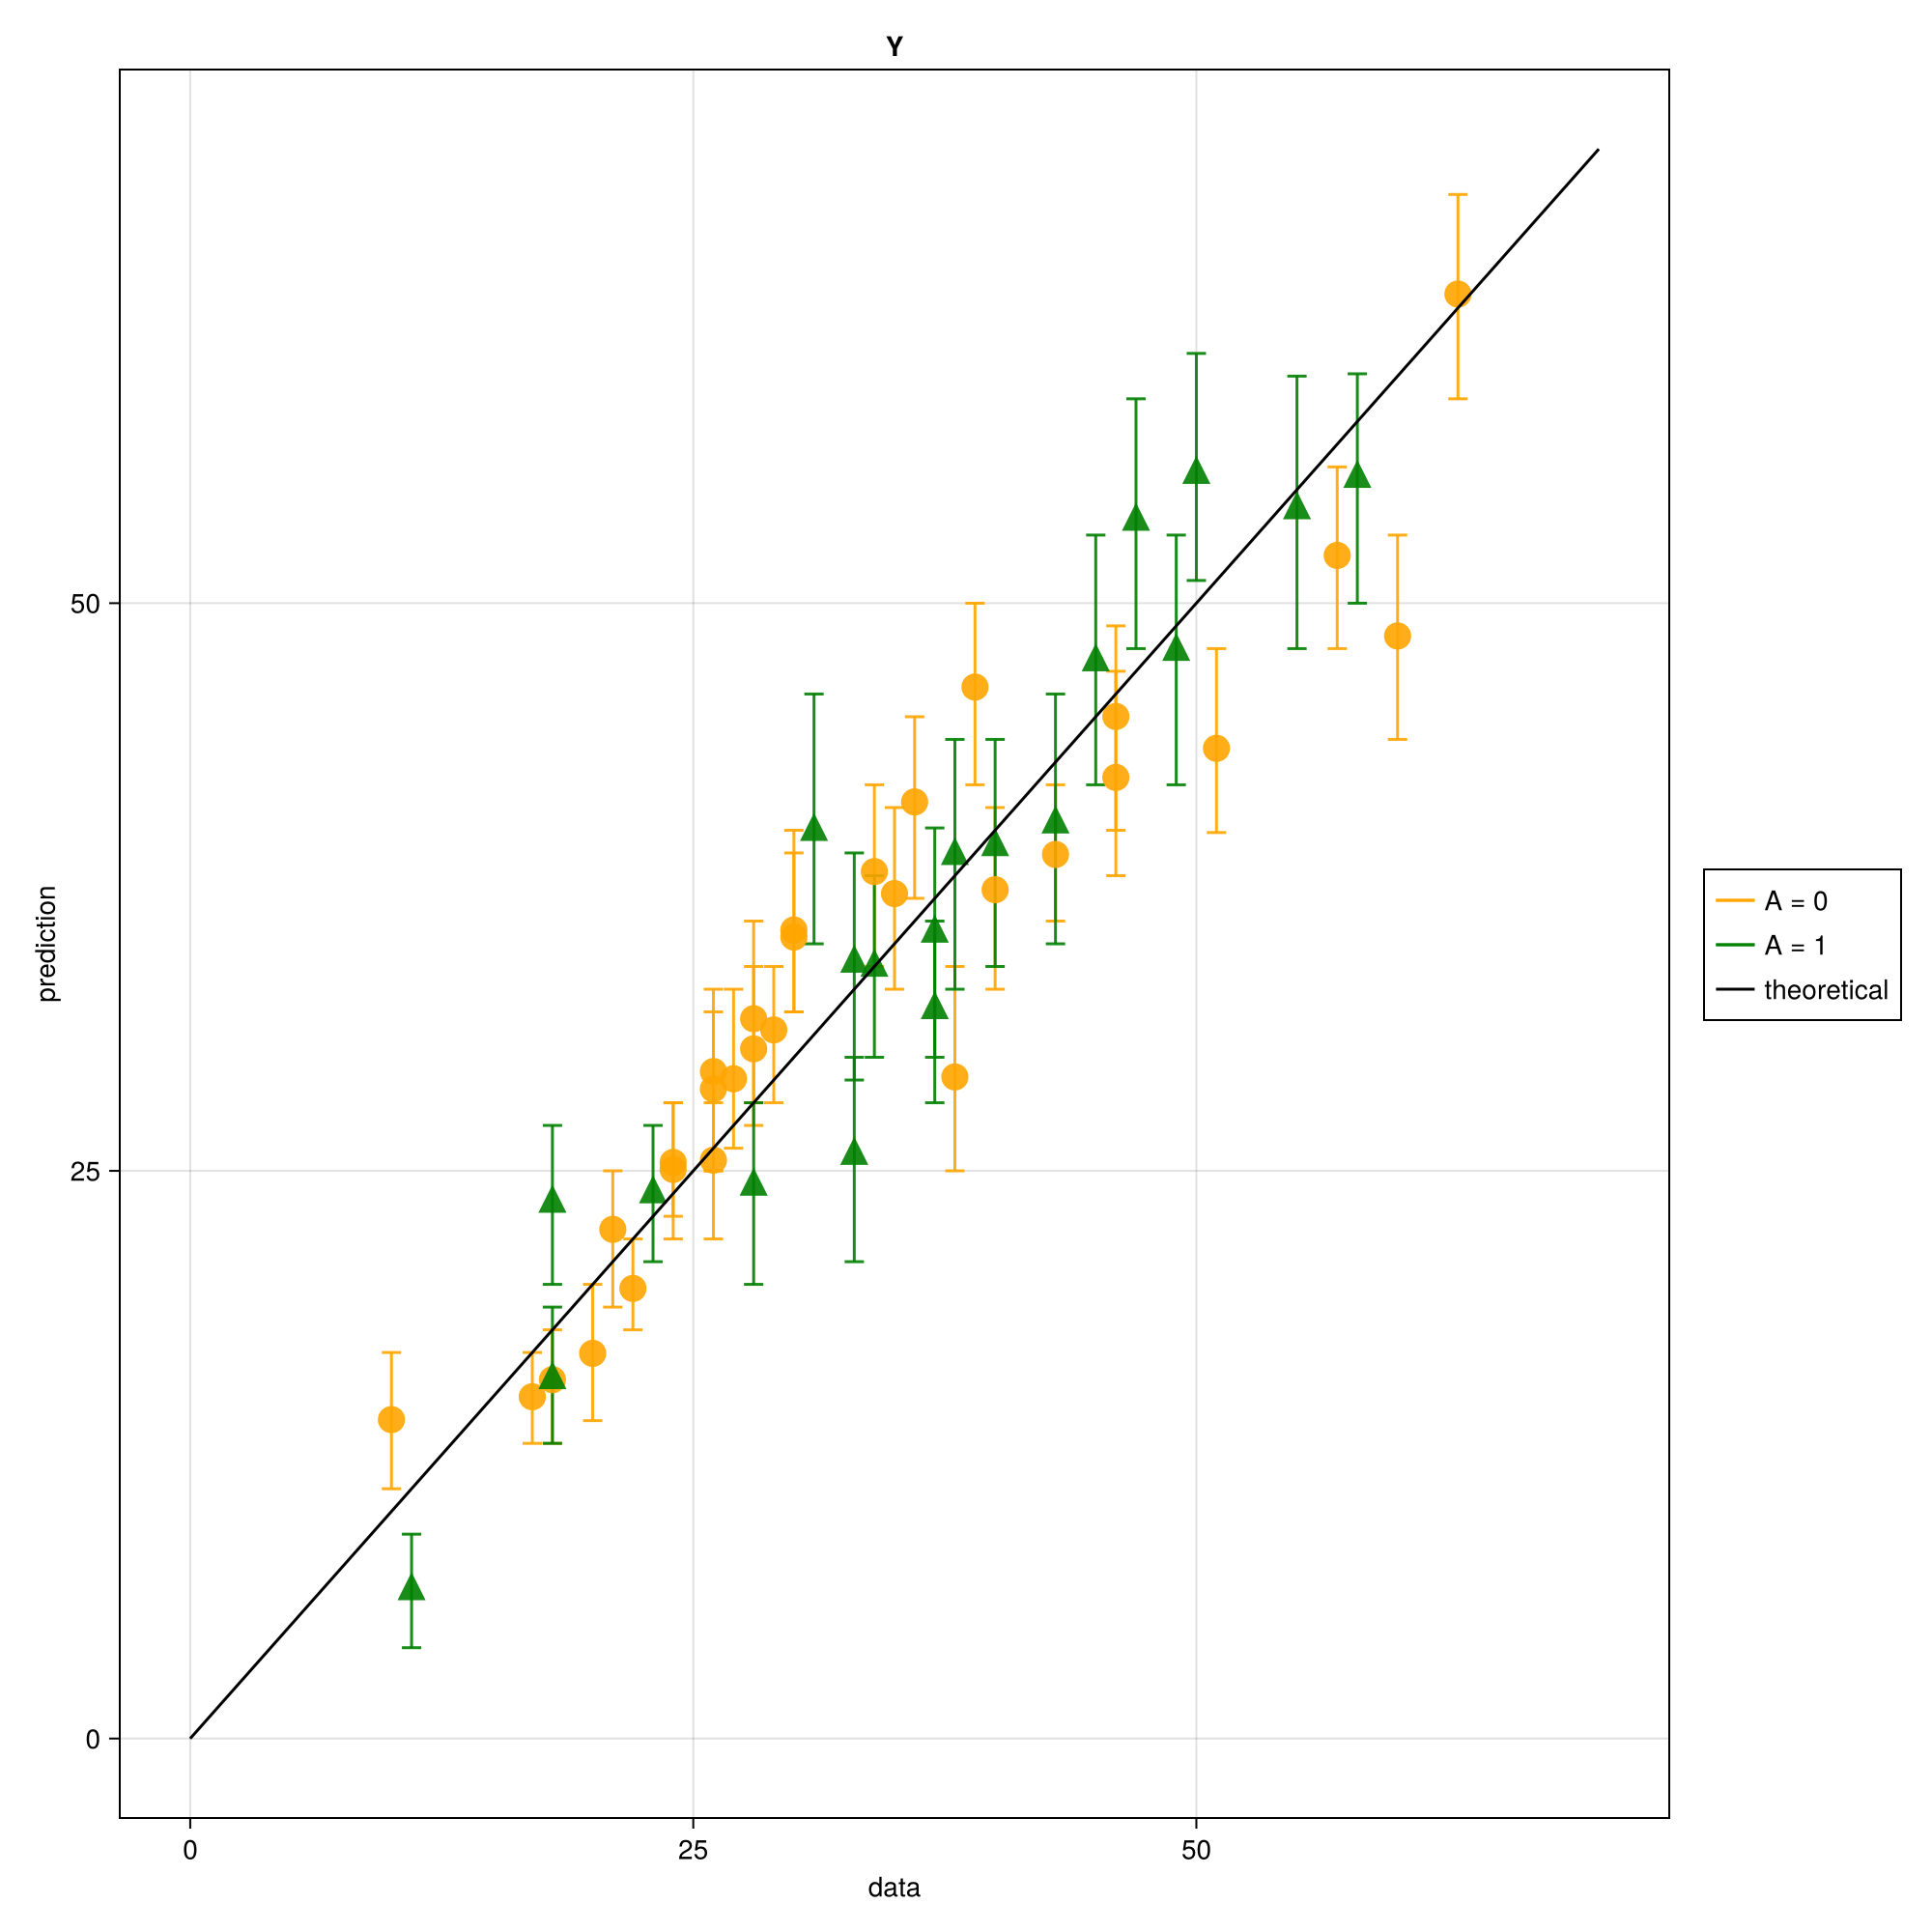

CairoMakie.Screen{IMAGE}


In [15]:
# 実測値・予測値 plot
fig = Figure(size=(1000, 1000))
ax = Axis(fig[1, 1], title="Y", xlabel="data", ylabel="prediction")

err1 = Makie.errorbars!(ax, df[A0, :Y], mean_Y_0, lower_errors_0, upper_errors_0, color = (:orange, 0.9), whiskerwidth = 10)
err2 = Makie.errorbars!(ax, df[A1, :Y], mean_Y_1, lower_errors_1, upper_errors_1, color = (:green, 0.9), whiskerwidth = 10)
Makie.scatter!(ax, df[A0, :Y], mean_Y_0, markersize = 20, marker = :circle, color = (:orange, 0.9))
Makie.scatter!(ax, df[A1, :Y], mean_Y_1, markersize = 20, marker = :utriangle, color = (:green, 0.9))
lin = Makie.lines!(ax, 0:1:70, x -> x, color=:black)

Legend(fig[1, 2], [err1, err2, lin], ["A = 0", "A = 1", "theoretical"])

display(fig)